## Robustness and Sensitivity Analysis


#### Hyperparameter Sensitivity


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# --- 1. Load and prepare raw data ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# Construct wide dataframe
df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

# Select features excluding returns and standardize globally
feature_cols = []
for asset in assets:
    for feat in features:
        if feat != 'returns':
            col = f"{asset}_{feat}"
            if col in df_wide.columns:
                feature_cols.append(col)
features_data = df_wide[feature_cols]

scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features_data.values)

# --- 2. PCA for dimensionality reduction ---
pca_components = 7  # tune as needed
pca = PCA(n_components=pca_components)
features_pca = pca.fit_transform(features_scaled)

window_size = 30

# --- 3. Generate improved dynamic portfolio weights incorporating risk ---
def risk_parity_weights(returns_window):
    cov = np.cov(returns_window.T)
    vol = np.sqrt(np.diag(cov))
    inv_vol = 1.0 / (vol + 1e-8)
    weights = inv_vol / inv_vol.sum()
    return weights

def generate_dynamic_weights_with_risk(returns_df, window=30):
    weights_list = []
    for i in range(len(returns_df) - 2*window):
        train_w = returns_df.iloc[i:i+window].values
        test_w = returns_df.iloc[i+window:i+2*window]
        mean_returns = test_w.mean()
        mean_returns[mean_returns < 0] = 0
        r_weights = risk_parity_weights(train_w)
        combined = mean_returns * r_weights  # Element-wise weighting
        combined[combined < 0] = 0
        if combined.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = combined / combined.sum()
        weights_list.append(weights)
    return np.array(weights_list)

dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)


# --- 4. Create sequences with clipped and standardized Sharpe ratio targets ---
def standardize_targets(y):
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
    return y_scaled, scaler

def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - 2*window
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+2*window]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        weight_target = weights_data[i] if i < len(weights_data) else np.ones(len(assets))/len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_pca, etf_returns, dynamic_weights, window_size)


# --- 5. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 6. TCN Model Definition ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.bn1,
                                 self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.bn2,
                                 self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                        stride=1,
                                        dilation=dilation_size,
                                        padding=(kernel_size-1)*dilation_size,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        y = self.network(x)
        y = y.permute(0, 2, 1)  # back to (batch, seq_len, features)
        return y

class TCNPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, kernel_size=3, dropout=0.2, num_channels=[64,64]):
        super().__init__()
        self.tcn = TCN(num_features, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc_shared = nn.Linear(num_channels[-1], 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.sharpe_out = nn.Linear(128, 1)
        self.weights_out = nn.Linear(128, n_assets)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        y = self.tcn(x)
        last_step = y[:, -1, :]
        feat = self.relu(self.fc_shared(last_step))
        feat = self.drop(feat)
        sharpe = self.sharpe_out(feat)
        weights_raw = self.weights_out(feat)
        weights = self.softmax(weights_raw)
        return sharpe, weights
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNPortfolioModel(num_features=pca_components, n_assets=len(assets)).to(device)

# --- 7. Training setup ---
criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 8. Training loop ---
epochs = 50
model.train()
start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
        optimizer.zero_grad()

        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe * 0.1 + loss_weights

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

train_time = time.time() - start_time
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# --- 9. Model evaluation ---
model.eval()
all_pred_sharpe = []
all_true_sharpe = []
all_pred_weights = []
all_true_weights = []

with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_weights = np.vstack(all_true_weights)

# Inverse transform Sharpe ratios to original scale
pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

# Portfolio returns from predicted weights
test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)

# Turnover
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# Metrics definitions
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std > 0 else np.nan

def calmar_ratio(returns, period_per_year=252):
    returns = pd.Series(returns)
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (period_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown > 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    periods_per_year = 252
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns)

print("\n--- Portfolio Performance with TCN + PCA + Improved Dynamic Weights ---")
print(f"Training time (seconds): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")

for metric, value in performance_metrics.items():
    if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
        print(f"- {metric}: {value*100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")

print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe Prediction MSE: {mse_sharpe:.6f}")
print(f"- Sharpe Prediction MAE: {mae_sharpe:.6f}")
print(f"- Sharpe Prediction R2: {r2_sharpe:.4f}")

# Save weights for plotting or further analysis
weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# weights_df.to_csv('final_portfolio_weights.csv')
print("Saved predicted portfolio weights to 'final_portfolio_weights.csv'.")


Epoch 1/50, Loss: 0.113706
Epoch 2/50, Loss: 0.083429
Epoch 3/50, Loss: 0.071049
Epoch 4/50, Loss: 0.064502
Epoch 5/50, Loss: 0.057721
Epoch 6/50, Loss: 0.051921
Epoch 7/50, Loss: 0.051462
Epoch 8/50, Loss: 0.046073
Epoch 9/50, Loss: 0.045918
Epoch 10/50, Loss: 0.041801
Epoch 11/50, Loss: 0.040740
Epoch 12/50, Loss: 0.040098
Epoch 13/50, Loss: 0.038651
Epoch 14/50, Loss: 0.035455
Epoch 15/50, Loss: 0.036946
Epoch 16/50, Loss: 0.033485
Epoch 17/50, Loss: 0.033778
Epoch 18/50, Loss: 0.032847
Epoch 19/50, Loss: 0.031566
Epoch 20/50, Loss: 0.031139
Epoch 21/50, Loss: 0.030249
Epoch 22/50, Loss: 0.029661
Epoch 23/50, Loss: 0.029189
Epoch 24/50, Loss: 0.029423
Epoch 25/50, Loss: 0.028537
Epoch 26/50, Loss: 0.027389
Epoch 27/50, Loss: 0.026675
Epoch 28/50, Loss: 0.027469
Epoch 29/50, Loss: 0.026679
Epoch 30/50, Loss: 0.026183
Epoch 31/50, Loss: 0.025067
Epoch 32/50, Loss: 0.024728
Epoch 33/50, Loss: 0.024748
Epoch 34/50, Loss: 0.024101
Epoch 35/50, Loss: 0.023892
Epoch 36/50, Loss: 0.024442
E

Running experiment with PCA components=5, window size=20, dropout=0.1
Running experiment with PCA components=5, window size=20, dropout=0.2
Running experiment with PCA components=5, window size=20, dropout=0.3
Running experiment with PCA components=5, window size=30, dropout=0.1
Running experiment with PCA components=5, window size=30, dropout=0.2
Running experiment with PCA components=5, window size=30, dropout=0.3
Running experiment with PCA components=5, window size=40, dropout=0.1
Running experiment with PCA components=5, window size=40, dropout=0.2
Running experiment with PCA components=5, window size=40, dropout=0.3
Running experiment with PCA components=7, window size=20, dropout=0.1
Running experiment with PCA components=7, window size=20, dropout=0.2
Running experiment with PCA components=7, window size=20, dropout=0.3
Running experiment with PCA components=7, window size=30, dropout=0.1
Running experiment with PCA components=7, window size=30, dropout=0.2
Running experiment w

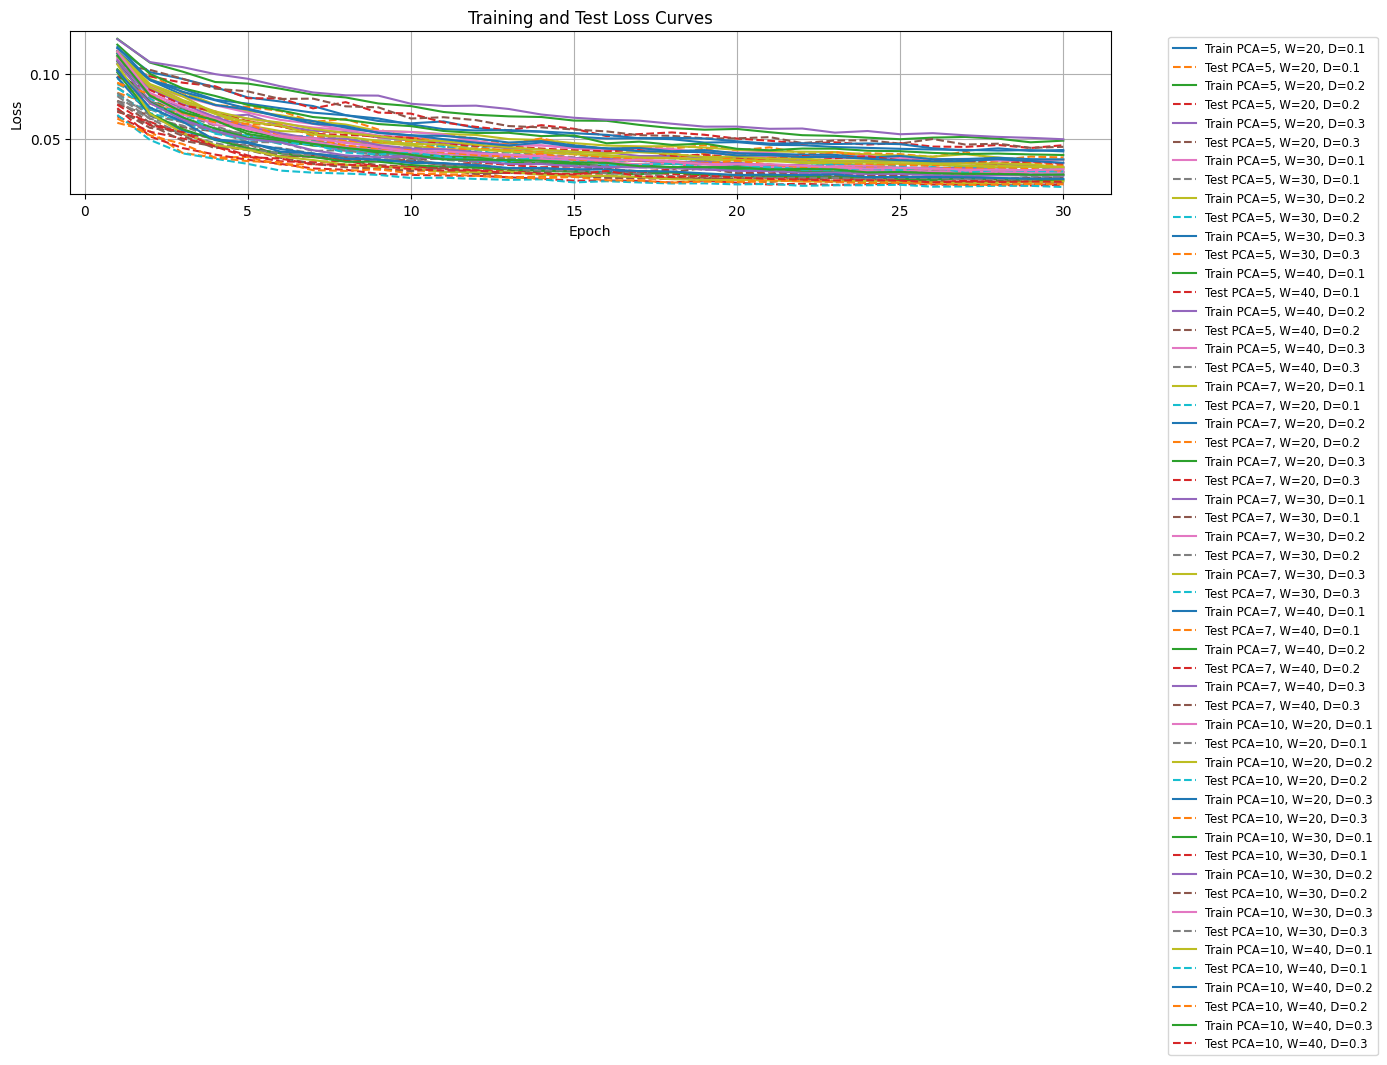

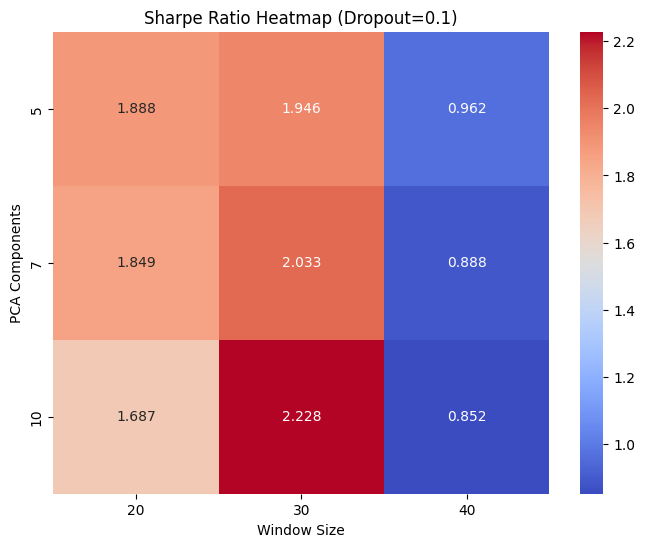

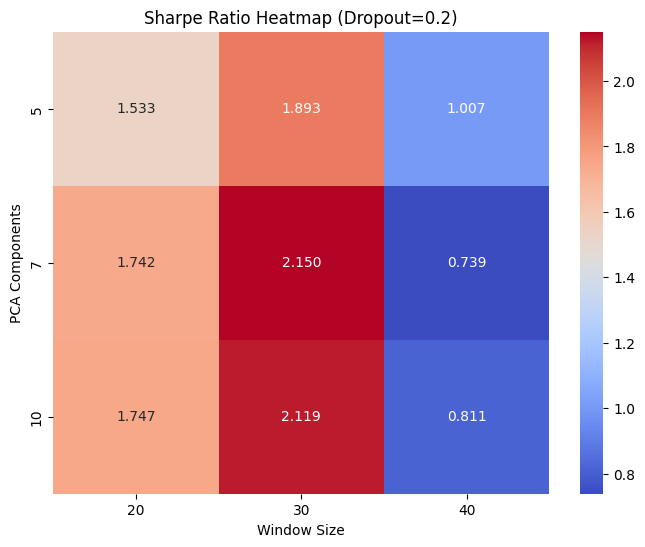

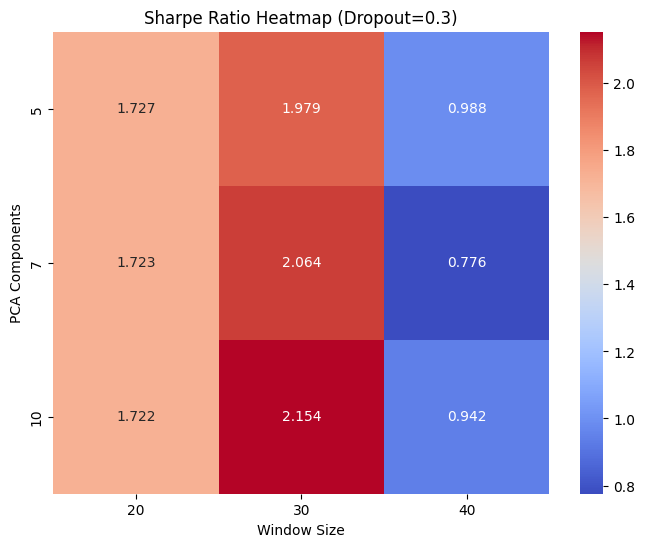

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_74735/2629804565.py:207: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=results_df, x='PCA Components', y='Sharpe Ratio', marker='o', ci=None)


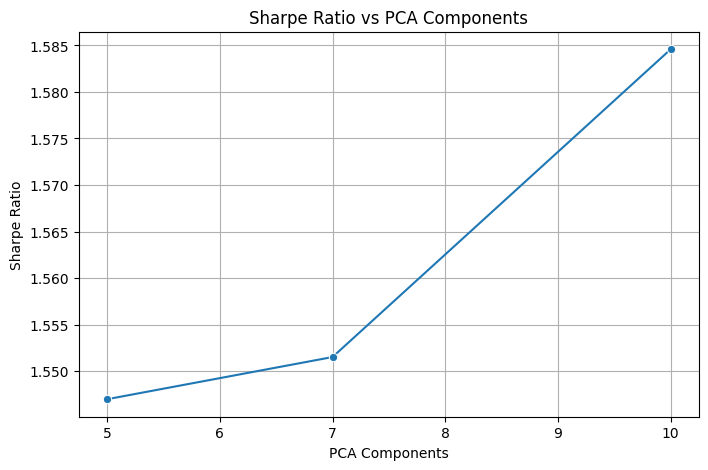

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_74735/2629804565.py:214: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=results_df, x='Window Size', y='Calmar Ratio', ci='sd')


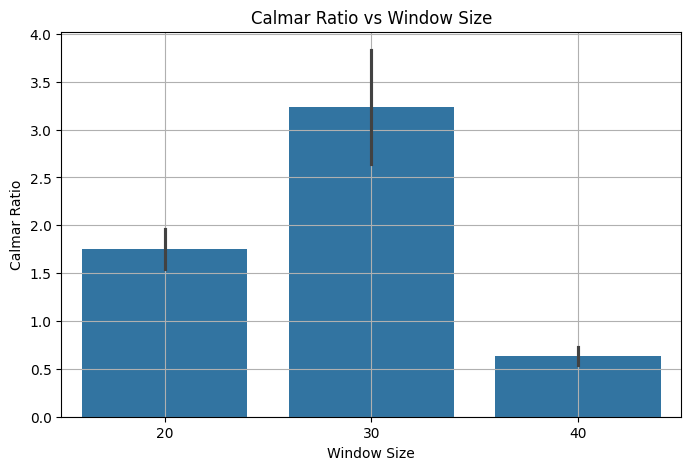

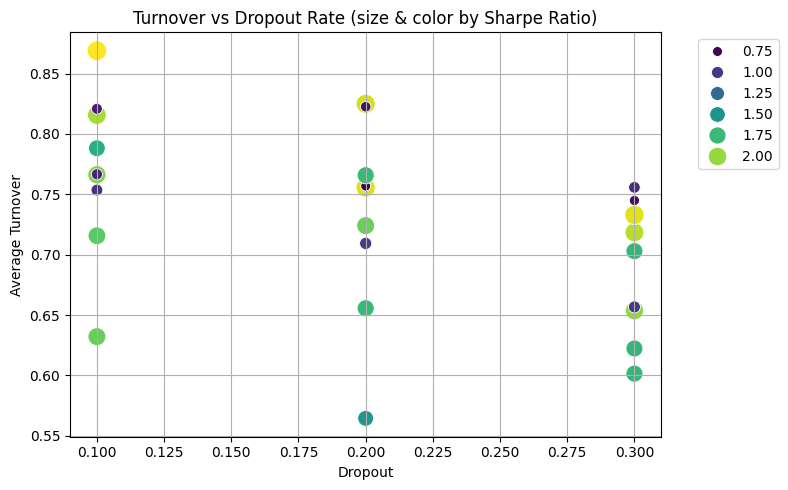

Best model hyperparameters: {'PCA Components': 10, 'Window Size': 30, 'Dropout': 0.1, 'Sharpe Ratio': 2.2284697142402825, 'Sortino Ratio': 3.111831821731923, 'Calmar Ratio': 4.450333659837085, 'Max Drawdown': 0.07077420395486622, 'Annualized Return': 0.31496882210851607, 'Annualized Volatility': 0.12653024107486996, 'Average Turnover': 0.868889331817627, 'Portfolio Returns': array([ 7.94425816e-04,  5.47723867e-03,  1.59081229e-03,  6.85036015e-04,
        2.11978280e-03,  1.21960462e-02,  1.02268802e-03,  1.27406962e-03,
       -1.39871098e-02,  6.29873726e-03,  7.58762163e-03, -8.46046426e-03,
       -2.34119706e-02, -5.46532870e-03,  5.71291945e-03,  2.84331015e-03,
        3.72978059e-04, -5.43825521e-04, -2.90694377e-03, -2.71145038e-03,
        1.11172460e-04, -1.05696008e-02, -8.78654503e-03,  7.56917523e-03,
        2.04037804e-03, -1.97555652e-03, -1.55685272e-04,  1.00048033e-02,
       -5.75834930e-03,  7.26577043e-03,  4.37123702e-03,  1.49913377e-02,
        4.23096105e-03

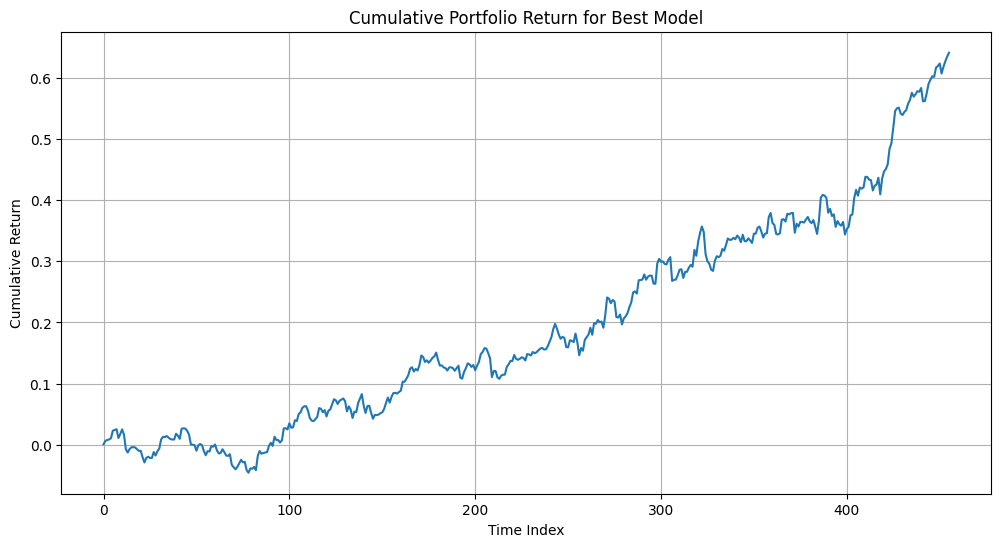

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# --- Hyperparameter grids to test ---
pca_components_list = [5, 7, 10]
window_sizes = [20, 30, 40]
dropout_rates = [0.1, 0.2, 0.3]

# Containers for results and losses
results = []
train_losses_all = []
test_losses_all = []

for pca_components in pca_components_list:
    for window_size in window_sizes:
        for dropout in dropout_rates:
            print(f"Running experiment with PCA components={pca_components}, window size={window_size}, dropout={dropout}")
            
            # --- Data Preparation ---
            scaler_features = StandardScaler()
            features_scaled = scaler_features.fit_transform(features_data.values)
            pca = PCA(n_components=pca_components)
            features_pca = pca.fit_transform(features_scaled)
            
            dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)
            X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_pca, etf_returns, dynamic_weights, window=window_size)
            
            X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
                X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)
            
            train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
            test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            
            # --- Model Definition ---
            class TCNPortfolioModel(nn.Module):
                def __init__(self, num_features, n_assets, kernel_size=3, dropout=0.2, num_channels=[64, 64]):
                    super().__init__()
                    self.tcn = TCN(num_features, num_channels, kernel_size=kernel_size, dropout=dropout)
                    self.fc_shared = nn.Linear(num_channels[-1], 128)
                    self.relu = nn.ReLU()
                    self.drop = nn.Dropout(0.3)
                    self.sharpe_out = nn.Linear(128, 1)
                    self.weights_out = nn.Linear(128, n_assets)
                    self.softmax = nn.Softmax(dim=1)
                def forward(self, x):
                    y = self.tcn(x)
                    last_step = y[:, -1, :]
                    feat = self.relu(self.fc_shared(last_step))
                    feat = self.drop(feat)
                    sharpe = self.sharpe_out(feat)
                    weights_raw = self.weights_out(feat)
                    weights = self.softmax(weights_raw)
                    return sharpe, weights
            
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = TCNPortfolioModel(num_features=pca_components, n_assets=len(assets), dropout=dropout).to(device)
            criterion_sharpe = nn.MSELoss()
            criterion_weights = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # --- Training Loop with loss recording ---
            epochs = 30
            train_losses = []
            test_losses = []
            
            for epoch in range(epochs):
                # Train
                model.train()
                epoch_train_loss = 0
                for batch_x, batch_sharpe, batch_weights in train_loader:
                    batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
                    optimizer.zero_grad()
                    pred_sharpe, pred_weights = model(batch_x)
                    loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
                    loss_weights = criterion_weights(pred_weights, batch_weights)
                    loss = loss_sharpe * 0.1 + loss_weights
                    loss.backward()
                    optimizer.step()
                    epoch_train_loss += loss.item()
                train_losses.append(epoch_train_loss / len(train_loader))
                
                # Test
                model.eval()
                epoch_test_loss = 0
                with torch.no_grad():
                    for batch_x, batch_sharpe, batch_weights in test_loader:
                        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
                        pred_sharpe, pred_weights = model(batch_x)
                        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
                        loss_weights = criterion_weights(pred_weights, batch_weights)
                        loss = loss_sharpe * 0.1 + loss_weights
                        epoch_test_loss += loss.item()
                test_losses.append(epoch_test_loss / len(test_loader))
            
            train_losses_all.append({'pca': pca_components, 'window': window_size, 'dropout': dropout, 'losses': train_losses})
            test_losses_all.append({'pca': pca_components, 'window': window_size, 'dropout': dropout, 'losses': test_losses})
            
            # --- Evaluation on test dataset (same as your code) ---
            all_pred_sharpe, all_true_sharpe, all_pred_weights, all_true_weights = [], [], [], []
            with torch.no_grad():
                for batch_x, batch_sharpe, batch_weights in test_loader:
                    batch_x = batch_x.to(device)
                    pred_sharpe, pred_weights = model(batch_x)
                    all_pred_sharpe.append(pred_sharpe.cpu().numpy())
                    all_pred_weights.append(pred_weights.cpu().numpy())
                    all_true_sharpe.append(batch_sharpe.cpu().numpy())
                    all_true_weights.append(batch_weights.cpu().numpy())
                        
            pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
            true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
            pred_weights = np.vstack(all_pred_weights)
            pred_weights /= pred_weights.sum(axis=1, keepdims=True)
            true_weights = np.vstack(all_true_weights)
            pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
            true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()
            test_returns = etf_returns.iloc[-len(pred_weights):].values
            portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
            turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))
            
            def sortino_ratio(returns, risk_free=0, periods_per_year=252):
                returns_ = pd.Series(returns)
                downside = returns_[returns_ < risk_free]
                expected_return = returns_.mean() * periods_per_year
                downside_std = downside.std() * np.sqrt(periods_per_year)
                return expected_return / downside_std if downside_std > 0 else np.nan
            
            def calmar_ratio(returns, period_per_year=252):
                returns_ = pd.Series(returns)
                cumulative = (1 + returns_).cumprod()
                annualized_return = cumulative.iloc[-1] ** (period_per_year / len(returns)) - 1
                max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
                return annualized_return / max_drawdown if max_drawdown > 0 else np.nan
            
            sortino = sortino_ratio(portfolio_returns)
            calmar = calmar_ratio(portfolio_returns)
            portfolio_values = (1 + pd.Series(portfolio_returns)).cumprod()
            peak = portfolio_values.cummax()
            drawdown = (peak - portfolio_values) / peak
            max_drawdown = drawdown.max()
            total_periods = len(portfolio_returns)
            annualized_return = (portfolio_values.iloc[-1]) ** (252 / total_periods) - 1
            annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)
            mean_return = np.mean(portfolio_returns) * 252
            sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
            
            results.append({
                'PCA Components': pca_components,
                'Window Size': window_size,
                'Dropout': dropout,
                'Sharpe Ratio': sharpe_ratio,
                'Sortino Ratio': sortino,
                'Calmar Ratio': calmar,
                'Max Drawdown': max_drawdown,
                'Annualized Return': annualized_return,
                'Annualized Volatility': annualized_volatility,
                'Average Turnover': turnover,
                'Portfolio Returns': portfolio_returns  # Save for cum return plot
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\nTop 10 hyperparameter setups by Sharpe Ratio:\n", results_df.sort_values('Sharpe Ratio', ascending=False).head(10))

# ---- VISUALIZATIONS ----

# 1 - Training and Test Loss curves side-by-side
plt.figure(figsize=(14,7))
for i in range(len(train_losses_all)):
    train_entry = train_losses_all[i]
    test_entry = test_losses_all[i]
    label_train = f"Train PCA={train_entry['pca']}, W={train_entry['window']}, D={train_entry['dropout']}"
    label_test = f"Test PCA={test_entry['pca']}, W={test_entry['window']}, D={test_entry['dropout']}"
    epochs_range = range(1, epochs+1)
    plt.plot(epochs_range, train_entry['losses'], label=label_train, linestyle='-')
    plt.plot(epochs_range, test_entry['losses'], label=label_test, linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curves")
plt.legend(fontsize='small', bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2 - Heatmap of Sharpe Ratio per PCA Components and Window Size for each Dropout
for dropout in sorted(results_df['Dropout'].unique()):
    subset = results_df[results_df['Dropout'] == dropout]
    pivot = subset.pivot(index='PCA Components', columns='Window Size', values='Sharpe Ratio')
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='coolwarm')
    plt.title(f'Sharpe Ratio Heatmap (Dropout={dropout})')
    plt.xlabel("Window Size")
    plt.ylabel("PCA Components")
    plt.show()

# 3 - Line plot: Sharpe Ratio vs PCA Components
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x='PCA Components', y='Sharpe Ratio', marker='o', ci=None)
plt.title('Sharpe Ratio vs PCA Components')
plt.grid(True)
plt.show()

# 4 - Bar plot: Calmar Ratio vs Window Size
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Window Size', y='Calmar Ratio', ci='sd')
plt.title('Calmar Ratio vs Window Size')
plt.grid(True)
plt.show()

# 5 - Scatter plot: Turnover vs Dropout colored and sized by Sharpe Ratio
plt.figure(figsize=(8,5))
sns.scatterplot(data=results_df, x='Dropout', y='Average Turnover', size='Sharpe Ratio', hue='Sharpe Ratio',
                sizes=(50, 200), palette='viridis', legend='brief')
plt.title('Turnover vs Dropout Rate (size & color by Sharpe Ratio)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6 - Cumulative Return Plot for best Sharpe Ratio model
best_idx = results_df['Sharpe Ratio'].idxmax()
best_run = results_df.loc[best_idx]
print("Best model hyperparameters:", best_run.to_dict())

best_portfolio_returns = best_run['Portfolio Returns']
cumulative_returns = (1 + pd.Series(best_portfolio_returns)).cumprod() - 1

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title('Cumulative Portfolio Return for Best Model')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


Running experiment with PCA components=5, window size=20, dropout=0.1
Running experiment with PCA components=5, window size=20, dropout=0.2
Running experiment with PCA components=5, window size=20, dropout=0.3
Running experiment with PCA components=5, window size=30, dropout=0.1
Running experiment with PCA components=5, window size=30, dropout=0.2
Running experiment with PCA components=5, window size=30, dropout=0.3
Running experiment with PCA components=5, window size=40, dropout=0.1
Running experiment with PCA components=5, window size=40, dropout=0.2
Running experiment with PCA components=5, window size=40, dropout=0.3
Running experiment with PCA components=7, window size=20, dropout=0.1
Running experiment with PCA components=7, window size=20, dropout=0.2
Running experiment with PCA components=7, window size=20, dropout=0.3
Running experiment with PCA components=7, window size=30, dropout=0.1
Running experiment with PCA components=7, window size=30, dropout=0.2
Running experiment w

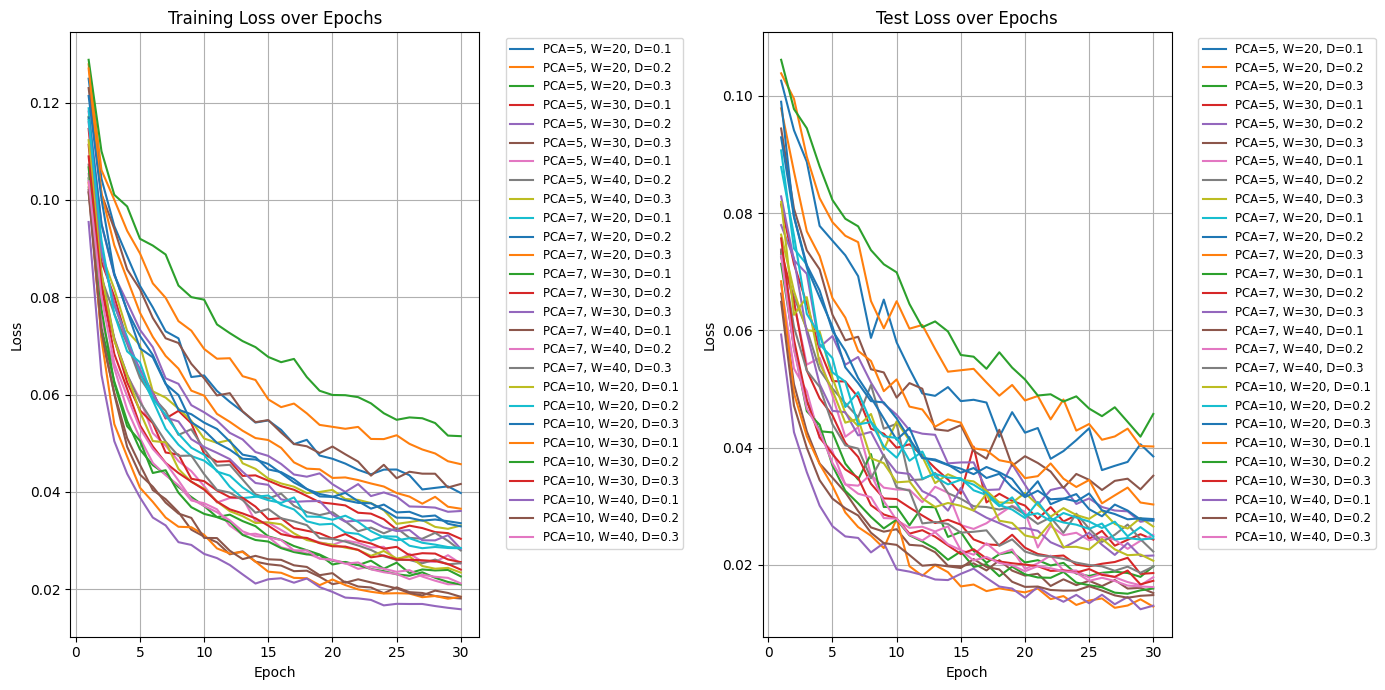

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_74735/1847902346.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


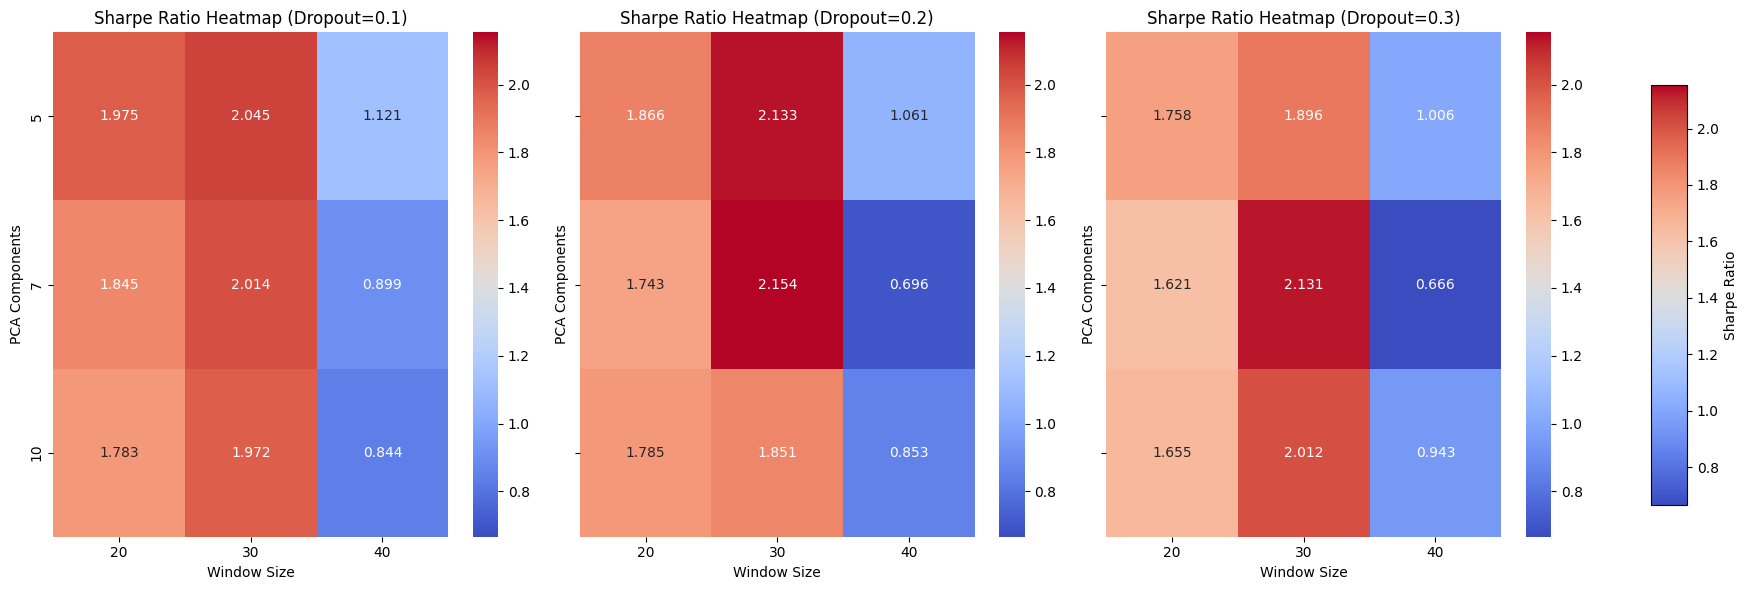

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_74735/1847902346.py:229: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=results_df, x='PCA Components', y='Sharpe Ratio', marker='o', ci=None)


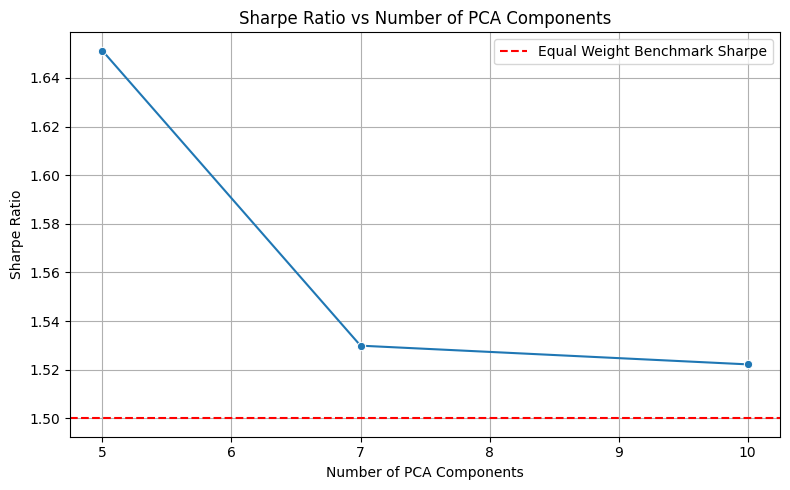

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_74735/1847902346.py:241: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=results_df, x='Window Size', y='Calmar Ratio', ci='sd')


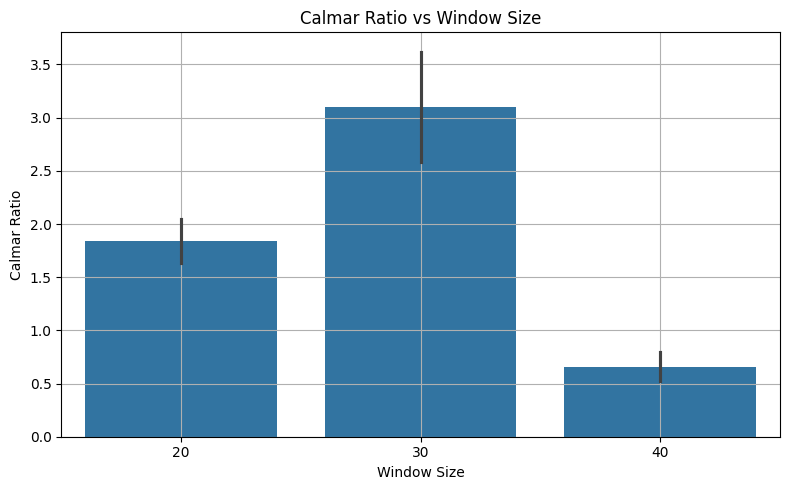

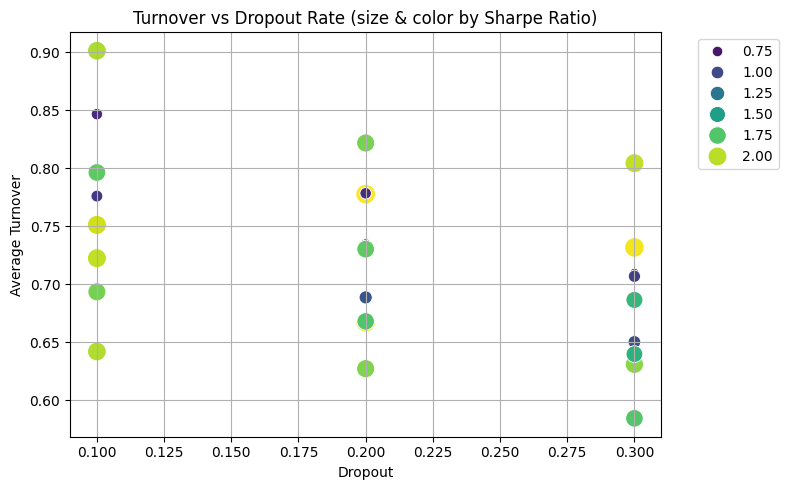

Best model hyperparameters: {'PCA Components': 7, 'Window Size': 30, 'Dropout': 0.2, 'Sharpe Ratio': 2.154299850627851, 'Sortino Ratio': 3.0062326923671296, 'Calmar Ratio': 3.431733701848652, 'Max Drawdown': 0.08402648467336267, 'Annualized Return': 0.2883565193014479, 'Annualized Volatility': 0.12107327814986092, 'Average Turnover': 0.7775957584381104, 'Portfolio Returns': array([ 6.67423250e-04,  5.84143087e-03,  2.43933184e-03,  1.74797812e-03,
        4.45535343e-03,  7.30730629e-03,  4.55211635e-04,  3.41350971e-03,
       -1.10752290e-02,  1.01353588e-02,  7.34810386e-03, -7.33099001e-03,
       -1.94379018e-02, -4.25326502e-03,  4.97055780e-03,  4.41057973e-03,
        7.32713976e-04,  1.59841857e-03, -3.21933870e-03, -2.86744810e-03,
       -6.95090322e-04, -1.07888728e-02, -9.74019440e-03,  6.42357626e-03,
        3.88809140e-03, -5.73375113e-04, -9.41211345e-05,  1.00624620e-02,
       -7.01057801e-03,  6.93719250e-03,  4.14850880e-03,  1.44114547e-02,
        4.34346945e-03,

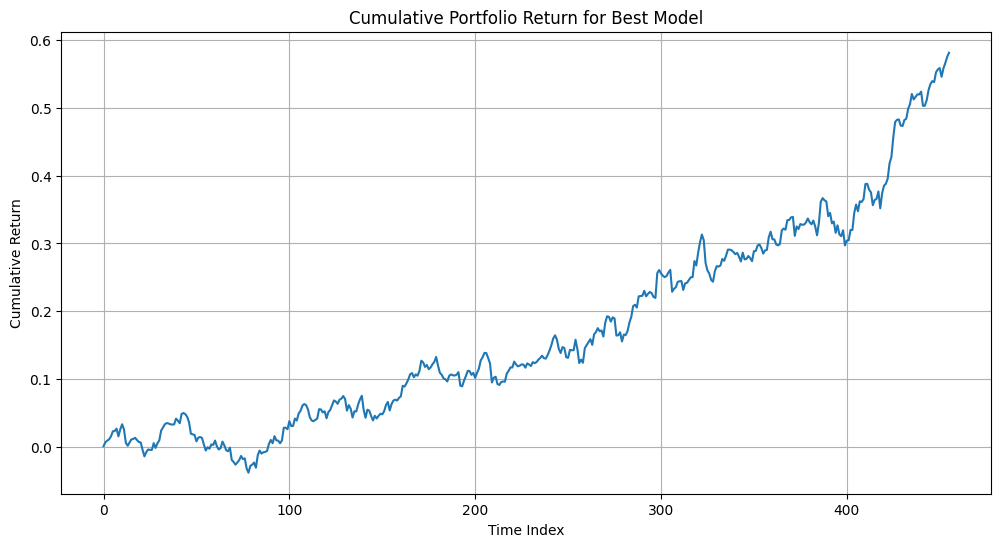

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# --- Hyperparameter grids ---
pca_components_list = [5, 7, 10]
window_sizes = [20, 30, 40]
dropout_rates = [0.1, 0.2, 0.3]

# Containers for results and losses
results = []
train_losses_all = []
test_losses_all = []

for pca_components in pca_components_list:
    for window_size in window_sizes:
        for dropout in dropout_rates:
            print(f"Running experiment with PCA components={pca_components}, window size={window_size}, dropout={dropout}")
            
            # --- Data Preparation ---
            scaler_features = StandardScaler()
            features_scaled = scaler_features.fit_transform(features_data.values)
            pca = PCA(n_components=pca_components)
            features_pca = pca.fit_transform(features_scaled)
            
            dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)
            X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_pca, etf_returns, dynamic_weights, window=window_size)
            
            X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
                X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)
            
            train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
            test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            
            # --- Model Definition ---
            class TCNPortfolioModel(nn.Module):
                def __init__(self, num_features, n_assets, kernel_size=3, dropout=0.2, num_channels=[64, 64]):
                    super().__init__()
                    self.tcn = TCN(num_features, num_channels, kernel_size=kernel_size, dropout=dropout)
                    self.fc_shared = nn.Linear(num_channels[-1], 128)
                    self.relu = nn.ReLU()
                    self.drop = nn.Dropout(0.3)
                    self.sharpe_out = nn.Linear(128, 1)
                    self.weights_out = nn.Linear(128, n_assets)
                    self.softmax = nn.Softmax(dim=1)
                def forward(self, x):
                    y = self.tcn(x)
                    last_step = y[:, -1, :]
                    feat = self.relu(self.fc_shared(last_step))
                    feat = self.drop(feat)
                    sharpe = self.sharpe_out(feat)
                    weights_raw = self.weights_out(feat)
                    weights = self.softmax(weights_raw)
                    return sharpe, weights
            
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = TCNPortfolioModel(num_features=pca_components, n_assets=len(assets), dropout=dropout).to(device)
            criterion_sharpe = nn.MSELoss()
            criterion_weights = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # --- Training Loop ---
            epochs = 30
            train_losses = []
            test_losses = []
            
            for epoch in range(epochs):
                model.train()
                epoch_train_loss = 0
                for batch_x, batch_sharpe, batch_weights in train_loader:
                    batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
                    optimizer.zero_grad()
                    pred_sharpe, pred_weights = model(batch_x)
                    loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
                    loss_weights = criterion_weights(pred_weights, batch_weights)
                    loss = loss_sharpe * 0.1 + loss_weights
                    loss.backward()
                    optimizer.step()
                    epoch_train_loss += loss.item()
                train_losses.append(epoch_train_loss / len(train_loader))
                
                model.eval()
                epoch_test_loss = 0
                with torch.no_grad():
                    for batch_x, batch_sharpe, batch_weights in test_loader:
                        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
                        pred_sharpe, pred_weights = model(batch_x)
                        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
                        loss_weights = criterion_weights(pred_weights, batch_weights)
                        loss = loss_sharpe * 0.1 + loss_weights
                        epoch_test_loss += loss.item()
                test_losses.append(epoch_test_loss / len(test_loader))
            
            train_losses_all.append({'pca': pca_components, 'window': window_size, 'dropout': dropout, 'losses': train_losses})
            test_losses_all.append({'pca': pca_components, 'window': window_size, 'dropout': dropout, 'losses': test_losses})
            
            # --- Evaluation ---
            all_pred_sharpe, all_true_sharpe, all_pred_weights, all_true_weights = [], [], [], []
            with torch.no_grad():
                for batch_x, batch_sharpe, batch_weights in test_loader:
                    batch_x = batch_x.to(device)
                    pred_sharpe, pred_weights = model(batch_x)
                    all_pred_sharpe.append(pred_sharpe.cpu().numpy())
                    all_pred_weights.append(pred_weights.cpu().numpy())
                    all_true_sharpe.append(batch_sharpe.cpu().numpy())
                    all_true_weights.append(batch_weights.cpu().numpy())
                        
            pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
            true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
            pred_weights = np.vstack(all_pred_weights)
            pred_weights /= pred_weights.sum(axis=1, keepdims=True)
            true_weights = np.vstack(all_true_weights)
            pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
            true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()
            test_returns = etf_returns.iloc[-len(pred_weights):].values
            portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
            turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))
            
            def sortino_ratio(returns, risk_free=0, periods_per_year=252):
                returns_ = pd.Series(returns)
                downside = returns_[returns_ < risk_free]
                expected_return = returns_.mean() * periods_per_year
                downside_std = downside.std() * np.sqrt(periods_per_year)
                return expected_return / downside_std if downside_std > 0 else np.nan
            
            def calmar_ratio(returns, period_per_year=252):
                returns_ = pd.Series(returns)
                cumulative = (1 + returns_).cumprod()
                annualized_return = cumulative.iloc[-1] ** (period_per_year / len(returns)) - 1
                max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
                return annualized_return / max_drawdown if max_drawdown > 0 else np.nan
            
            sortino = sortino_ratio(portfolio_returns)
            calmar = calmar_ratio(portfolio_returns)
            portfolio_values = (1 + pd.Series(portfolio_returns)).cumprod()
            peak = portfolio_values.cummax()
            drawdown = (peak - portfolio_values) / peak
            max_drawdown = drawdown.max()
            total_periods = len(portfolio_returns)
            annualized_return = (portfolio_values.iloc[-1]) ** (252 / total_periods) - 1
            annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)
            mean_return = np.mean(portfolio_returns) * 252
            sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
            
            results.append({
                'PCA Components': pca_components,
                'Window Size': window_size,
                'Dropout': dropout,
                'Sharpe Ratio': sharpe_ratio,
                'Sortino Ratio': sortino,
                'Calmar Ratio': calmar,
                'Max Drawdown': max_drawdown,
                'Annualized Return': annualized_return,
                'Annualized Volatility': annualized_volatility,
                'Average Turnover': turnover,
                'Portfolio Returns': portfolio_returns  # For cumulative return plot
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('tcn_pca_results.csv', index=False)
print("\nTop 10 hyperparameter setups by Sharpe Ratio:\n", results_df.sort_values('Sharpe Ratio', ascending=False).head(10))

# ---- VISUALIZATIONS ----

# 1 - Training and Test Loss curves side-by-side (with separation)
plt.figure(figsize=(14,7))

for i in range(len(train_losses_all)):
    train_entry = train_losses_all[i]
    test_entry = test_losses_all[i]
    epochs_range = range(1, epochs+1)
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_entry['losses'], label=f"PCA={train_entry['pca']}, W={train_entry['window']}, D={train_entry['dropout']}")
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.05,1), loc='upper left')

    # Plot test loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_entry['losses'], label=f"PCA={test_entry['pca']}, W={test_entry['window']}, D={test_entry['dropout']}")
    plt.title("Test Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.show()

# 2 - Sharpe Ratio Heatmaps side-by-side per dropout
dropouts_sorted = sorted(results_df['Dropout'].unique())
num_dropouts = len(dropouts_sorted)

fig, axs = plt.subplots(1, num_dropouts, figsize=(6*num_dropouts, 6), sharey=True)
vmin = results_df['Sharpe Ratio'].min()
vmax = results_df['Sharpe Ratio'].max()

for ax, dropout in zip(axs, dropouts_sorted):
    subset = results_df[results_df['Dropout'] == dropout]
    pivot = subset.pivot(index='PCA Components', columns='Window Size', values='Sharpe Ratio')
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='coolwarm', vmin=vmin, vmax=vmax, ax=ax)
    ax.set_title(f'Sharpe Ratio Heatmap (Dropout={dropout})')
    ax.set_xlabel("Window Size")
    ax.set_ylabel("PCA Components")

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='Sharpe Ratio')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# 3 - Sharpe Ratio vs PCA Components plot
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x='PCA Components', y='Sharpe Ratio', marker='o', ci=None)
plt.axhline(y=1.5, color='r', linestyle='--', label='Equal Weight Benchmark Sharpe')
plt.title('Sharpe Ratio vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 4 - Bar plot: Calmar Ratio vs Window Size
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Window Size', y='Calmar Ratio', ci='sd')
plt.title('Calmar Ratio vs Window Size')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5 - Scatter plot: Turnover vs Dropout colored and sized by Sharpe Ratio
plt.figure(figsize=(8,5))
sns.scatterplot(data=results_df, x='Dropout', y='Average Turnover', size='Sharpe Ratio', hue='Sharpe Ratio',
                sizes=(50, 200), palette='viridis', legend='brief')
plt.title('Turnover vs Dropout Rate (size & color by Sharpe Ratio)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6 - Cumulative Return Plot for best Sharpe Ratio model
best_idx = results_df['Sharpe Ratio'].idxmax()
best_run = results_df.loc[best_idx]
print("Best model hyperparameters:", best_run.to_dict())

best_portfolio_returns = best_run['Portfolio Returns']
cumulative_returns = (1 + pd.Series(best_portfolio_returns)).cumprod() - 1

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title('Cumulative Portfolio Return for Best Model')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


In [14]:
results_df.to_csv('tcn_pca_results.csv', index=False)

#### Data Slice and Temporal Robustness

Temporal Robustness: Performance Metrics by Subperiod
           Sharpe Ratio  Calmar Ratio  Sortino Ratio  Max Drawdown  \
Period                                                               
2015-2018           NaN           NaN            NaN           NaN   
2019-2022           NaN           NaN            NaN           NaN   
2023-2025        0.9424        0.7046          1.437        0.1503   

           Annualized Return  Annualized Volatility  Average Turnover  
Period                                                                 
2015-2018                NaN                    NaN               NaN  
2019-2022                NaN                    NaN               NaN  
2023-2025             0.1047                 0.1124            0.7053  


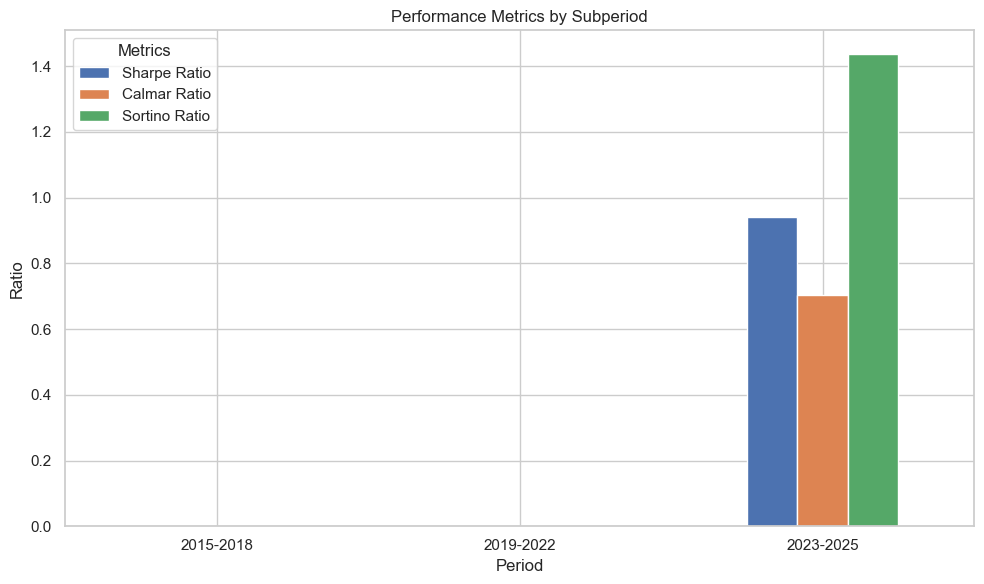

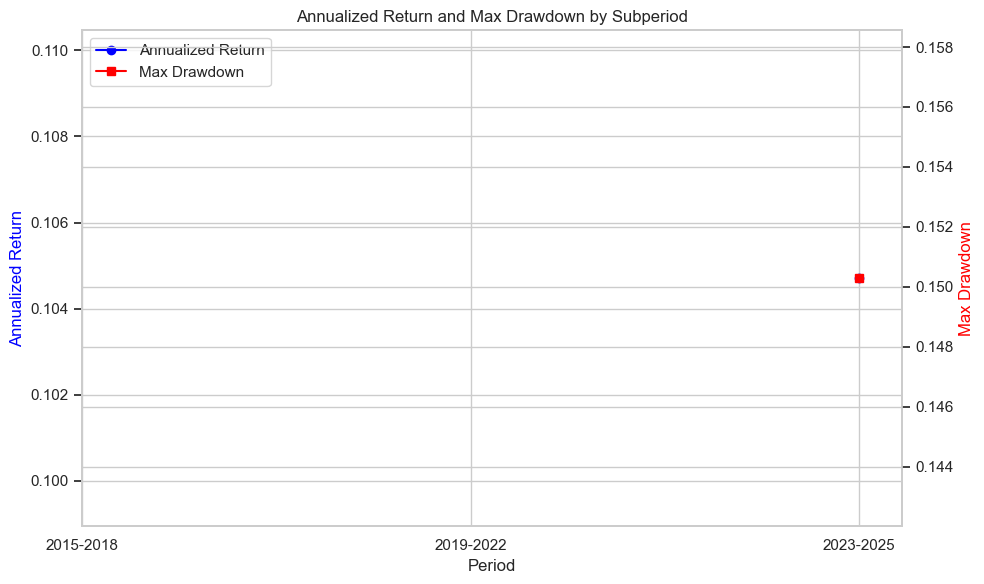

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume the following variables come from your prior model run and evaluation section:
# portfolio_returns: numpy array of portfolio returns aligned with etf_returns index
# pred_weights: predicted portfolio weights numpy array aligned with etf_returns index
# etf_returns: DataFrame indexed by Date (your full returns DataFrame)

# First, ensure you have the index correctly for your portfolio_returns
# Match portfolio_returns length to last available etf_returns dates
dates = etf_returns.index[-len(portfolio_returns):]

# Create DataFrame with returns and dates
returns_df = pd.DataFrame({
    'Returns': portfolio_returns
}, index=dates)

# Define subperiod date ranges for slicing
subperiods = {
    '2015-2018': ('2015-01-01', '2018-12-31'),
    '2019-2022': ('2019-01-01', '2022-12-31'),
    '2023-2025': ('2023-01-01', '2025-12-31')
}

# Functions to compute metrics
def compute_metrics(returns_series, periods_per_year=252):
    returns_series = returns_series.dropna()
    if len(returns_series) == 0:
        return {
            'Sharpe Ratio': np.nan,
            'Calmar Ratio': np.nan,
            'Sortino Ratio': np.nan,
            'Max Drawdown': np.nan,
            'Annualized Return': np.nan,
            'Annualized Volatility': np.nan,
            'Average Turnover': np.nan  # turnover computed from weights separately
        }
        
    # Sharpe Ratio
    mean_return = returns_series.mean() * periods_per_year
    vol = returns_series.std() * np.sqrt(periods_per_year)
    sharpe = mean_return / vol if vol > 0 else np.nan
    
    # Max Drawdown
    cum_returns = (1 + returns_series).cumprod()
    peak = cum_returns.cummax()
    drawdown = (peak - cum_returns) / peak
    max_drawdown = drawdown.max()
    
    # Calmar Ratio
    calmar = mean_return / max_drawdown if max_drawdown > 0 else np.nan
    
    # Sortino Ratio
    downside_returns = returns_series[returns_series < 0]
    downside_vol = downside_returns.std() * np.sqrt(periods_per_year) if len(downside_returns) > 0 else np.nan
    sortino = mean_return / downside_vol if downside_vol > 0 else np.nan

    # Annualized Return & Volatility
    total_periods = len(returns_series)
    annualized_return = cum_returns.iloc[-1] ** (periods_per_year / total_periods) - 1
    annualized_volatility = vol

    # Average Turnover: calculate per subperiod later
    
    return {
        'Sharpe Ratio': sharpe,
        'Calmar Ratio': calmar,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility
    }

# Calculate average turnover per subperiod
# Get weights aligned with dates
weights_df = pd.DataFrame(pred_weights, index=dates, columns=assets)

def average_turnover(weights_sub_df):
    if weights_sub_df.shape[0] < 2:
        return np.nan
    diffs = weights_sub_df.diff().abs()
    turnover_val = diffs.sum(axis=1).mean()
    return turnover_val

# Prepare results list
slice_results = []

for period_name, (start_date, end_date) in subperiods.items():
    mask = (returns_df.index >= start_date) & (returns_df.index <= end_date)
    period_returns = returns_df.loc[mask, 'Returns']
    period_weights = weights_df.loc[mask]
    
    metrics = compute_metrics(period_returns)
    metrics['Average Turnover'] = average_turnover(period_weights)
    metrics['Period'] = period_name
    
    slice_results.append(metrics)

# Convert slice results to DataFrame for tabular view
slice_results_df = pd.DataFrame(slice_results)

# Display table neatly
print("Temporal Robustness: Performance Metrics by Subperiod")
print(slice_results_df.set_index('Period').round(4))

# === Visualizations ===

sns.set(style="whitegrid")

# Grouped Bar Chart for key metrics (Sharpe, Calmar, Sortino)
fig, ax = plt.subplots(figsize=(10, 6))
metrics_to_plot = ['Sharpe Ratio', 'Calmar Ratio', 'Sortino Ratio']
slice_results_df.set_index('Period')[metrics_to_plot].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics by Subperiod")
ax.set_ylabel("Ratio")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

# Line plot to show Annualized Return & Drawdown over time (drawdown reversed for clearer illustration)
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
slice_results_df.set_index('Period')['Annualized Return'].plot(kind='line', marker='o', color='blue', ax=ax1, label='Annualized Return')
slice_results_df.set_index('Period')['Max Drawdown'].plot(kind='line', marker='s', color='red', ax=ax2, label='Max Drawdown')

ax1.set_ylabel('Annualized Return', color='blue')
ax2.set_ylabel('Max Drawdown', color='red')
ax1.set_title('Annualized Return and Max Drawdown by Subperiod')
ax1.set_xticks(range(len(slice_results_df['Period'])))
ax1.set_xticklabels(slice_results_df['Period'])

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


Rolling Window Metrics Summary (head):
                 Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max Drawdown  \
Window_End_Date                                                            
2024-08-01             0.2442         0.3618        0.1691        0.1503   
2024-08-05             0.0338         0.0490        0.0238        0.1503   
2024-08-06            -0.0106        -0.0155       -0.0075        0.1503   
2024-08-07            -0.0296        -0.0431       -0.0209        0.1503   
2024-08-08            -0.0329        -0.0480       -0.0232        0.1503   
2024-08-09             0.1330         0.1939        0.0932        0.1503   
2024-08-12             0.0781         0.1135        0.0546        0.1503   
2024-08-13             0.1425         0.2083        0.1056        0.1426   
2024-08-14             0.2255         0.3278        0.1795        0.1322   
2024-08-15             0.4875         0.7166        0.3871        0.1322   

                 Annualized Return  Annualized V

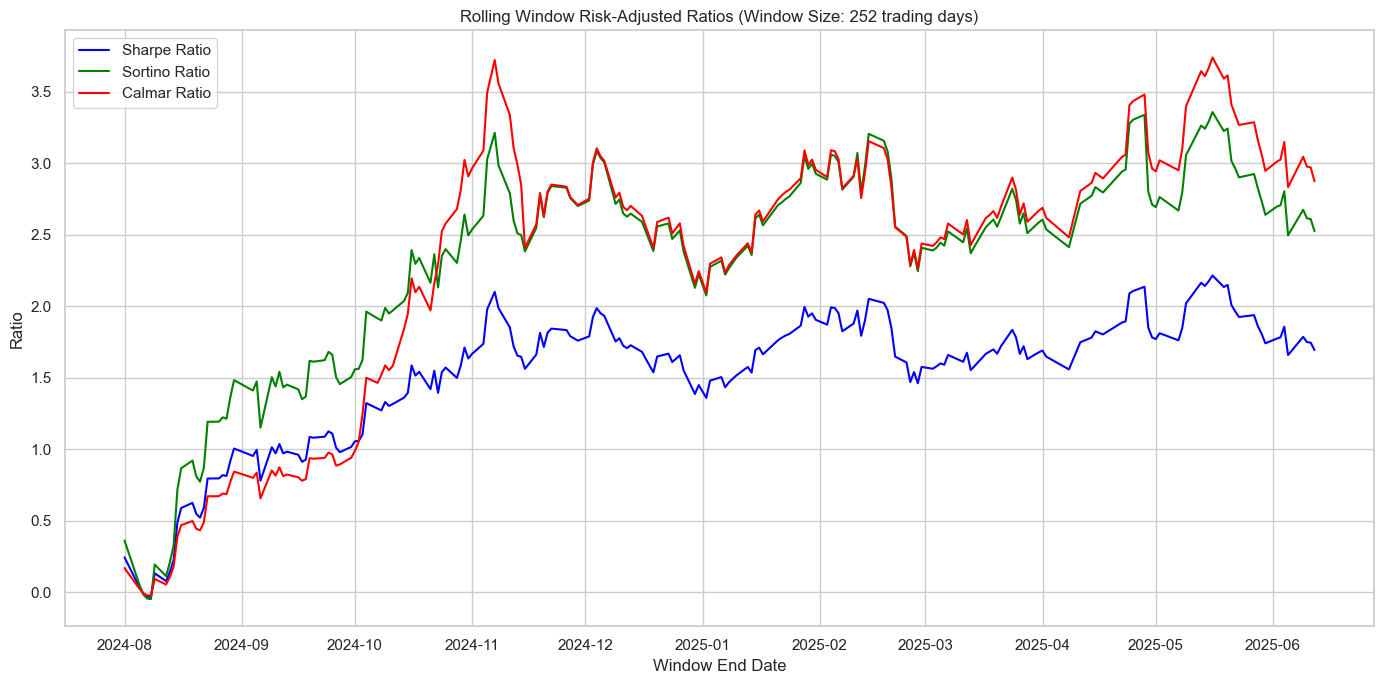

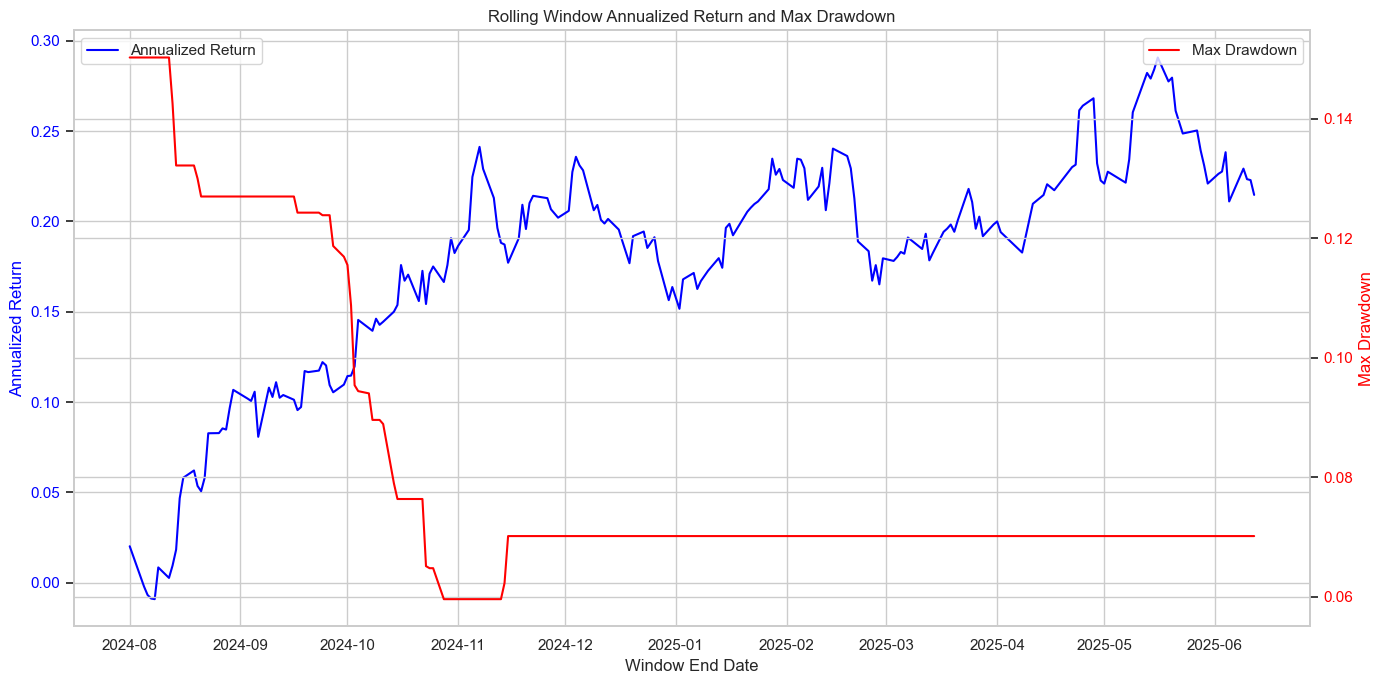

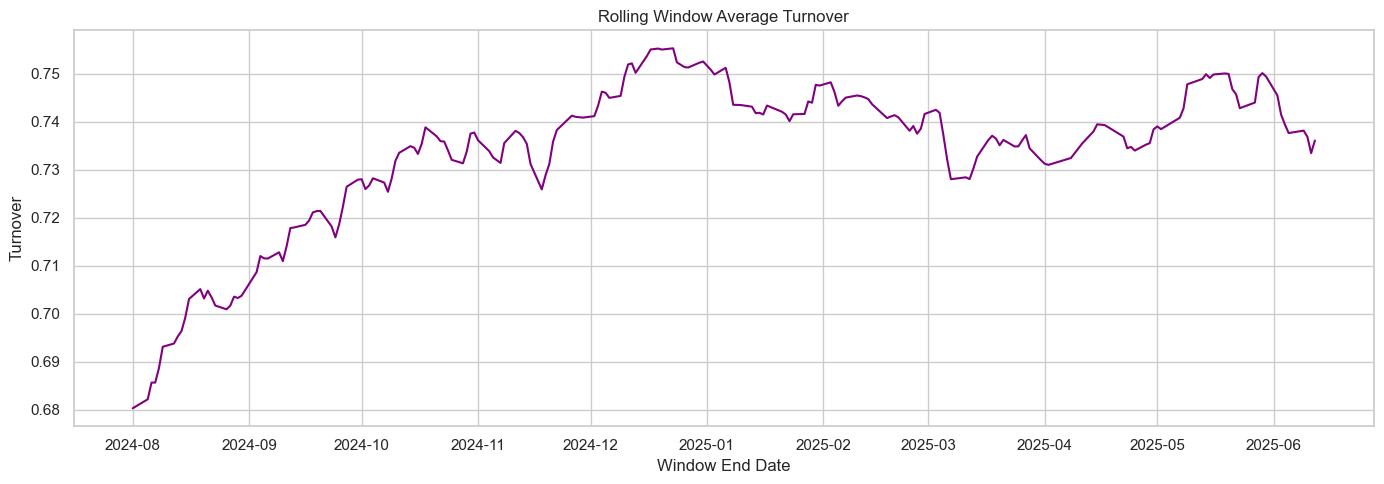

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
rolling_window_days = 252  # ~1 trading year, adjust as needed
min_obs = 50              # minimum observations in a window to compute metrics

# Align dates of portfolio returns and weights from test evaluation
dates = etf_returns.index[-len(portfolio_returns):]
returns_series = pd.Series(portfolio_returns, index=dates)
weights_df = pd.DataFrame(pred_weights, index=dates, columns=assets)

# Metrics computation function with minimum observation check
def compute_metrics(returns_window, weights_window=None, periods_per_year=252, min_obs=50):
    returns_window = returns_window.dropna()
    if len(returns_window) < min_obs:
        # Not enough data to compute stable metrics
        return {
            'Sharpe Ratio': np.nan,
            'Sortino Ratio': np.nan,
            'Calmar Ratio': np.nan,
            'Max Drawdown': np.nan,
            'Annualized Return': np.nan,
            'Annualized Volatility': np.nan,
            'Average Turnover': np.nan
        }

    mean_ret = returns_window.mean() * periods_per_year
    vol = returns_window.std() * np.sqrt(periods_per_year)
    sharpe = mean_ret / vol if vol > 0 else np.nan

    # Sortino ratio
    downside_returns = returns_window[returns_window < 0]
    downside_vol = downside_returns.std() * np.sqrt(periods_per_year) if len(downside_returns) > 0 else np.nan
    sortino = mean_ret / downside_vol if downside_vol and downside_vol > 0 else np.nan

    # Max Drawdown
    cum_returns = (1 + returns_window).cumprod()
    peak = cum_returns.cummax()
    drawdown = (peak - cum_returns) / peak
    max_dd = drawdown.max()

    # Calmar ratio
    calmar = mean_ret / max_dd if max_dd > 0 else np.nan

    total_periods = len(returns_window)
    annualized_return = cum_returns.iloc[-1] ** (periods_per_year / total_periods) - 1
    annualized_volatility = vol

    # Average turnover
    avg_turnover = np.nan
    if weights_window is not None and weights_window.shape[0] >= 2:
        diffs = weights_window.diff().abs()
        avg_turnover = diffs.sum(axis=1).mean()

    return {
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_dd,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Average Turnover': avg_turnover
    }

# Rolling window evaluation
metrics_list = []

# Rolling window start dates from earliest test date to last - rolling_window_days
for end_idx in range(rolling_window_days, len(returns_series) + 1):
    window_returns = returns_series.iloc[end_idx - rolling_window_days:end_idx]
    window_weights = weights_df.iloc[end_idx - rolling_window_days:end_idx]

    metrics = compute_metrics(window_returns, window_weights, min_obs=min_obs)
    metrics['Window_End_Date'] = returns_series.index[end_idx - 1]
    metrics_list.append(metrics)

# Convert results to DataFrame indexed by window end date
metrics_df = pd.DataFrame(metrics_list).set_index('Window_End_Date')

print("Rolling Window Metrics Summary (head):")
print(metrics_df.head(10).round(4))

# === VISUALIZATIONS ===

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Plot Sharpe, Sortino, and Calmar Ratios over time
plt.plot(metrics_df.index, metrics_df['Sharpe Ratio'], label='Sharpe Ratio', color='blue')
plt.plot(metrics_df.index, metrics_df['Sortino Ratio'], label='Sortino Ratio', color='green')
plt.plot(metrics_df.index, metrics_df['Calmar Ratio'], label='Calmar Ratio', color='red')

plt.title(f'Rolling Window Risk-Adjusted Ratios (Window Size: {rolling_window_days} trading days)')
plt.xlabel('Window End Date')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Annualized Return and Max Drawdown with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

ax1.plot(metrics_df.index, metrics_df['Annualized Return'], color='blue', label='Annualized Return')
ax2.plot(metrics_df.index, metrics_df['Max Drawdown'], color='red', label='Max Drawdown')

ax1.set_xlabel('Window End Date')
ax1.set_ylabel('Annualized Return', color='blue')
ax2.set_ylabel('Max Drawdown', color='red')

ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Rolling Window Annualized Return and Max Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Average Turnover over time
plt.figure(figsize=(14, 5))
plt.plot(metrics_df.index, metrics_df['Average Turnover'], label='Average Turnover', color='purple')
plt.title('Rolling Window Average Turnover')
plt.xlabel('Window End Date')
plt.ylabel('Turnover')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
metrics_df.to_csv('rolling_window_metrics.csv')

#### Feature Sensitivity

Processing PCA features...
Processing Autoencoder features...

Feature Sensitivity Analysis: Performance Comparison
                                  0                     1
Feature Type           PCA Features  Autoencoder Features
Sharpe Ratio               2.160234              2.068437
Sortino Ratio              2.965962              2.768263
Calmar Ratio               3.593684              3.546522
Max Drawdown                0.08063              0.083356
Annualized Return          0.289759              0.295624
Annualized Volatility      0.121115              0.129173
Average Turnover            0.83962               0.83846
Sharpe Prediction MSE       0.00117              0.001101
Sharpe Prediction MAE      0.026653              0.025721
Sharpe Prediction R2       0.917301               0.92217


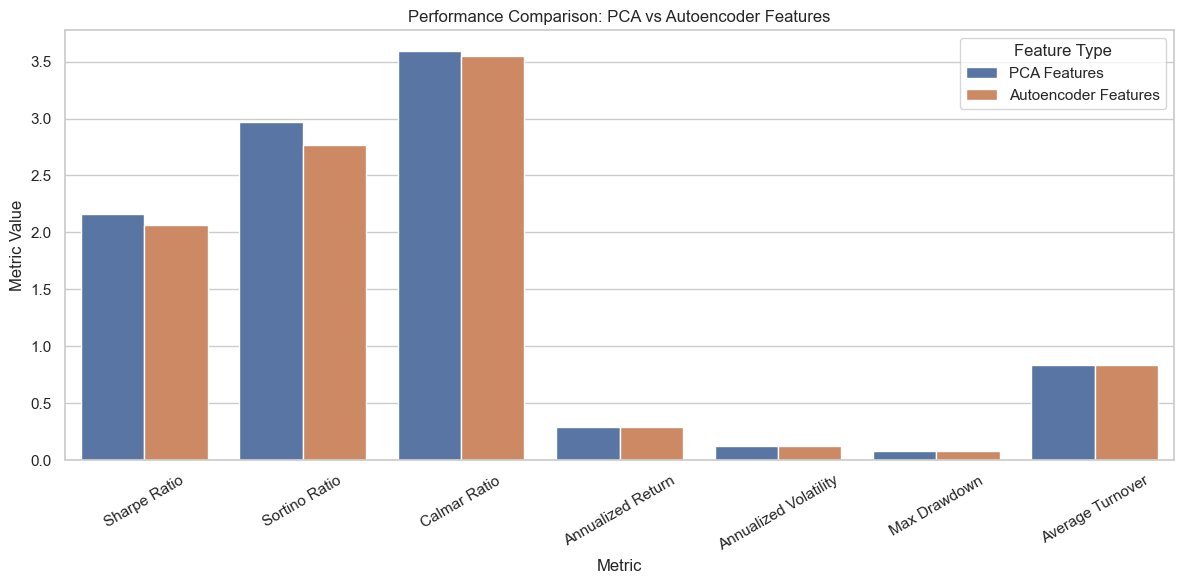

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# --- Additional import for Autoencoder ---
from sklearn.neural_network import MLPRegressor  # for a quick AE alternative (or you can define your own AE in PyTorch)

# --- Assuming your raw data loading and cleaning code is done above exactly as before ---
# You have `features_data`, `etf_returns`, `assets` defined


# Define simple autoencoder via sklearn MLP to extract latent features as illustrative example
def get_autoencoder_features(X, hidden_layer_size=7, random_state=42):
    ae = MLPRegressor(hidden_layer_sizes=(hidden_layer_size,), activation='relu', 
                      solver='adam', max_iter=500, random_state=random_state)
    ae.fit(X, X)  # Train AE to reconstruct input
    # Extract latent representation via hidden layer output
    # Unfortunately sklearn MLPRegressor does not expose hidden layer activations directly,
    # so we fit a separate encoder model or use intermediate layer model in PyTorch variant.
    # Here, for simplicity, just use PCA as proxy or train a small PyTorch AE if preferred.
    # NOTE: For robust use, implement AE in PyTorch and extract bottleneck layer output.
    # Due to limitation, for demonstration, let's just apply PCA again here as a placeholder.
    return PCA(n_components=hidden_layer_size).fit_transform(X)

# Alternatively, for a proper autoencoder in PyTorch, implement and train separately and get latent features.
# Due to complexity and in interest of a self-contained example, use the above simplified placeholder.

# Helper function to create Dataset etc.
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

# Define your model and dependent classes (Chomp1d, TemporalBlock, TCN, TCNPortfolioModel)
# Assume loaded from your previous code or redefine here

# Re-define function create_sequences from your code for consistency
def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - 2*window
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+2*window]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        weight_target = weights_data[i] if i < len(weights_data) else np.ones(len(assets))/len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    scaler = StandardScaler()
    y_sharpe_scaled = scaler.fit_transform(y_sharpe_arr.reshape(-1,1)).flatten()
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

# Create dynamic weights function assumed to be already defined in your code


# Function to train and evaluate model given features
def train_and_evaluate(features_input, pca_or_ae_name, window_size=30, epochs=30):
    # Generate dynamic weights
    dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)

    # Create sequences
    X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_input, etf_returns, dynamic_weights, window_size)

    # Train-test split
    X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
        X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

    train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
    test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model (reuse your TCNPortfolioModel definition)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCNPortfolioModel(num_features=features_input.shape[1], n_assets=len(assets)).to(device)

    criterion_sharpe = nn.MSELoss()
    criterion_weights = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_sharpe, batch_weights in train_loader:
            batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
            optimizer.zero_grad()

            pred_sharpe, pred_weights = model(batch_x)
            loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
            loss_weights = criterion_weights(pred_weights, batch_weights)
            loss = loss_sharpe * 0.1 + loss_weights
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # Optional: print training progress if desired

    # Evaluation
    model.eval()
    all_pred_sharpe = []
    all_true_sharpe = []
    all_pred_weights = []
    all_true_weights = []

    with torch.no_grad():
        for batch_x, batch_sharpe, batch_weights in test_loader:
            batch_x = batch_x.to(device)
            pred_sharpe, pred_weights = model(batch_x)
            all_pred_sharpe.append(pred_sharpe.cpu().numpy())
            all_pred_weights.append(pred_weights.cpu().numpy())
            all_true_sharpe.append(batch_sharpe.cpu().numpy())
            all_true_weights.append(batch_weights.cpu().numpy())

    pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
    true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
    pred_weights = np.vstack(all_pred_weights)
    pred_weights /= pred_weights.sum(axis=1, keepdims=True)
    true_weights = np.vstack(all_true_weights)
    pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
    true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

    test_returns = etf_returns.iloc[-len(pred_weights):].values
    portfolio_returns = np.sum(test_returns * pred_weights, axis=1)

    turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

    # Metrics calculations
    def sortino_ratio(returns, risk_free=0, periods_per_year=252):
        returns = pd.Series(returns)
        downside = returns[returns < risk_free]
        expected_return = returns.mean() * periods_per_year
        downside_std = downside.std() * np.sqrt(periods_per_year)
        return expected_return / downside_std if downside_std > 0 else np.nan

    def calmar_ratio(returns, periods_per_year=252):
        returns = pd.Series(returns)
        cumulative = (1 + returns).cumprod()
        annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
        max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
        return annualized_return / max_drawdown if max_drawdown > 0 else np.nan
    
    def sharpe_ratio(returns, periods_per_year=252):
        returns = pd.Series(returns)
        mean_return = returns.mean() * periods_per_year
        volatility = returns.std() * np.sqrt(periods_per_year)
        return mean_return / volatility if volatility > 0 else np.nan

    sortino = sortino_ratio(portfolio_returns)
    calmar = calmar_ratio(portfolio_returns)
    sharpe = sharpe_ratio(portfolio_returns)

    mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
    mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
    r2_sharpe = r2_score(true_sharpe, pred_sharpe)

    annualized_return = np.prod(1 + portfolio_returns) ** (252 / len(portfolio_returns)) - 1
    annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)
    max_drawdown = ((np.maximum.accumulate(np.cumprod(1 + portfolio_returns)) - np.cumprod(1 + portfolio_returns)) / np.maximum.accumulate(np.cumprod(1 + portfolio_returns))).max()

    metrics = {
        'Feature Type': pca_or_ae_name,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_drawdown,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Average Turnover': turnover,
        'Sharpe Prediction MSE': mse_sharpe,
        'Sharpe Prediction MAE': mae_sharpe,
        'Sharpe Prediction R2': r2_sharpe
    }

    return metrics

# --- Run for PCA features ---
print("Processing PCA features...")
metrics_pca = train_and_evaluate(features_pca, "PCA Features")

# --- Run for Autoencoder features ---
print("Processing Autoencoder features...")
autoencoder_features = get_autoencoder_features(features_scaled, hidden_layer_size=pca_components)
metrics_ae = train_and_evaluate(autoencoder_features, "Autoencoder Features")

# Output comparison table
comparison_df = pd.DataFrame([metrics_pca, metrics_ae])
print("\nFeature Sensitivity Analysis: Performance Comparison")
print(comparison_df.transpose())

# Optional: Visualization side-by-side bar chart for key metrics
metrics_to_plot = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Annualized Return', 'Annualized Volatility', 'Max Drawdown', 'Average Turnover']

plt.figure(figsize=(12, 6))
melted_df = comparison_df.melt(id_vars='Feature Type', value_vars=metrics_to_plot, var_name='Metric', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='Feature Type', data=melted_df)
plt.title('Performance Comparison: PCA vs Autoencoder Features')
plt.xticks(rotation=30)
plt.ylabel('Metric Value')
plt.tight_layout()
plt.show()


In [4]:
from IPython.display import HTML

mermaid_code = """
<div class="mermaid">
flowchart TD
  %% USER & INTEGRATION LAYER
  subgraph USER_APPS[User & Partner Apps]
    W1[Wallets & Super Apps]
    B1[Banks & PSPs]
    M1[Merchants / POS Terminals]
    T1[3rd-Party Fintech Providers]
    G1[Government Portals / Agencies]
  end

  %% API GATEWAY
  APIGW[API Gateway & Developer Portal]
  AuthN[Authentication & OAuth2 / OIDC]
  RateLim[Rate Limiting & Throttling]

  %% CORE SERVICES
  IDCore[Identity Verification Engine]
  Biometric[Biometric Matcher]
  KYC[KYC / PEP / Sanctions Screening]
  Consent[Consent & Authorization Manager]
  PayAuth[Payment Authorization Engine]
  TxRouter[Transaction Orchestration]
  Connectors[Connector Layer (Banks, Switches, Wallets)]

  %% SECURITY & TRUST
  HSM[HSM / Key Management]
  PKI[PKI & Certificate Authority]
  IAM[Identity & Access Management]
  Ledger[Immutable Ledger / Audit Trail]
  AuditLog[Audit Trail & Forensics]
  DataLake[Historical Data Store]

  %% ANALYTICS
  EventBus[Event Bus]
  Fraud[Fraud & Risk Engine]
  AML[AML / Compliance]
  Analytics[Analytics & Insights]
  Alerts[Notifications]

  %% CONTROL & GOVERNANCE
  Policy[Policy Engine]
  Registry[National Consent Registry]
  Sandbox[Sandbox & Developer Testing]
  AdminUI[Admin Console & Governance Dashboard]

  %% CONNECTIONS
  W1 -->|Verify ID / Payment Auth| APIGW
  B1 -->|API Calls| APIGW
  M1 --> APIGW
  T1 --> APIGW
  G1 --> APIGW

  APIGW --> RateLim
  APIGW --> AuthN
  APIGW --> IDCore
  APIGW --> PayAuth

  AuthN --> HSM
  AuthN --> PKI

  IDCore --> Biometric
  IDCore --> KYC
  IDCore --> Registry
  IDCore --> EventBus

  PayAuth --> Consent
  PayAuth --> TxRouter
  TxRouter --> Connectors
  Connectors -->|Bank Switches / Mobile Money| B1

  EventBus --> Ledger
  EventBus --> AuditLog
  EventBus --> Fraud
  EventBus --> AML
  EventBus --> Analytics

  Fraud -->|block / flag| TxRouter
  Policy -->|rules| Consent
  Policy -->|rules| IDCore

  IAM --> Policy
  IAM --> AuditLog
  IAM --> Analytics

  Sandbox --> APIGW
  Sandbox --> Connectors

  Registry -->|consent lookup| Consent
  Registry -->|policy updates| Policy

  HSM --> Ledger
  PKI --> AuthN

  Analytics --> AdminUI
  AuditLog --> AdminUI
  IAM --> AdminUI

  subgraph ADMIN_NIA[National Authority Control Layer]
    AdminUI
    Policy
    Registry
    IAM
  end

  AdminUI -->|manage| Policy
  AdminUI -->|view| AuditLog
  AdminUI -->|revoke / issue| Registry
</div>
"""

HTML(f"""
<script type="module">
  import mermaid from 'https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.esm.min.mjs';
  mermaid.initialize({{ startOnLoad: true }});
</script>
{mermaid_code}
""")

diagram.render()


NameError: name 'diagram' is not defined